In [1]:
'''
Extracts RV data for the table in the paper.
Outputs the table
'''

'\nExtracts RV data for the table in the paper.\nOutputs the table\n'

In [2]:
import numpy as np
import csv
from tabulate import tabulate
from texttable import Texttable
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "./forecaster/")
import mr_forecast as mr

import astropy.stats
from astropy import constants as apc

pi = np.pi

MJUPITER = apc.M_jup.value
MEARTH = apc.M_earth.value
MSUN = apc.M_sun.value

RJUPITER = apc.R_jup.value
REARTH = apc.R_earth.value
RSUN = apc.R_sun.value

AU = apc.au.value
BIGG = apc.G.value

In [3]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [4]:
my_file = 'C:/Users/djhoo/Documents/Oviraptor-master/catalogues/oviraptor_crossmatch_catalog_v2.csv'  #reading in file

raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[0]
VALUES = raw_data[2::2]

def get_key(keyname, keys = KEYS, values = VALUES):
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return np.array(arr)

In [5]:
d = {}
d['starname'] = get_key('hostname')
d['rs'] = get_key('st_rad')
d['rs_lower'] = get_key('st_raderr2')
d['rs_upper'] = get_key('st_raderr1')
d['ms'] = get_key('st_mass')
d['ms_lower'] = get_key('st_masserr2')
d['ms_upper'] = get_key('st_masserr1')
d['disc_method'] = get_key('system_disc_method')
d['mag'] = get_key('sy_vmag')
d['temp'] = get_key('st_teff')
d['ref'] = get_key('st_refname')
d['instrument'] = get_key('disc_facility')
d['rp'] = get_key('pl_rade')
d['rp_err1'] = get_key('pl_radeerr1')
d['rp_err2'] = get_key('pl_radeerr2')
d['mp'] = get_key('pl_bmasse')
d['mp_err1'] = get_key('pl_bmasseerr1')
d['mp_err2'] = get_key('pl_bmasseerr2')
d['p'] = get_key('pl_orbper')

In [6]:
# convert numerical quantities to floats; set missing values to np.nan
for k in d.keys():
    if (k[-11:] != "disc_method")*(k != "starname")*(k != 'ref')*(k != 'instrument'):
        
        arr = np.zeros(len(d["starname"]))

        for i, entry in enumerate(d[k]):
            if entry == "":
                arr[i] = np.nan
            else:
                arr[i] = float(entry)
                
        d[k] = np.copy(arr)

In [7]:
# count up the planets in each system
d["npl"] = np.zeros(len(d["starname"]), dtype="int")

for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))

# remove systems with fewer than 3 planets
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    
print("After removing systems with N < 3, {0} objects in {1} systems remain"
      .format(np.sum(keep), len(np.unique(d["starname"]))))

After removing systems with N < 3, 842 objects in 239 systems remain


In [8]:
# remove systems with missing stellar mass or radius
bad = np.isnan(d["ms"]) + np.isnan(d["rs"])

print("Removed the following systems with missing Mstar or Rstar")
for star in np.unique(d["starname"][bad]):
    print(star)   
    
for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removals, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))

Removed the following systems with missing Mstar or Rstar
Kepler-257
Kepler-359

After removals, 836 objects in 237 systems remain


In [9]:
# fix one-sided Mstar uncertainties
for i, star in enumerate(d["starname"]):
    if np.isnan(d["ms_lower"][i]) + ~np.isnan(d["ms_upper"][i]):
        d["ms_lower"][i] = -d["ms_upper"][i]
    if ~np.isnan(d["ms_lower"][i]) + np.isnan(d["ms_upper"][i]):
        d["ms_upper"][i] = -d["ms_lower"][i]
        

# flag systems with no stellar mass uncertainty
bad = np.isnan(d["ms_lower"]) + np.isnan(d["ms_upper"])


print("The following systems have missing uncertainty on Mstar")
for star in np.unique(d["starname"][bad]):
    print(star)

The following systems have missing uncertainty on Mstar


In [10]:
# fix one-sided Rstar uncertainties
for i, star in enumerate(d["starname"]):
    if np.isnan(d["rs_lower"][i]) + ~np.isnan(d["rs_upper"][i]):
        d["rs_lower"][i] = -d["rs_upper"][i]
    if ~np.isnan(d["rs_lower"][i]) + np.isnan(d["rs_upper"][i]):
        d["rs_upper"][i] = -d["rs_lower"][i]

        
# flag systems with no stellar radius uncertainty
bad = np.isnan(d["rs_lower"]) + np.isnan(d["rs_upper"])


print("The following systems have missing uncertainty on Rstar")
for star in np.unique(d["starname"][bad]):
    print(star)

The following systems have missing uncertainty on Rstar


In [11]:
# remove systems with missing stellar mass or radius uncertainty
# or if their stellar mass or radius uncertainty
bad = np.isnan(d["rs_lower"]) + np.isnan(d["rs_upper"]) + \
        np.isnan(d["ms_lower"]) + np.isnan(d["ms_upper"])

for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removing stars with missing mass/radius uncertainty, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))


After removing stars with missing mass/radius uncertainty, 836 objects in 237 systems remain


In [12]:
# flag systems with only an upper/lower limit on planet mass or radius
bad  = np.isnan(d["rp_err1"]) * ~np.isnan(d["rp_err2"])
bad += ~np.isnan(d["rp_err1"]) * np.isnan(d["rp_err2"])

d["rp"][bad] = np.nan
d["rp_err1"][bad] = np.nan
d["rp_err2"][bad] = np.nan

bad  = np.isnan(d["mp_err1"]) * ~np.isnan(d["mp_err2"])
bad += ~np.isnan(d["mp_err1"]) * np.isnan(d["mp_err2"])

d["mp"][bad] = np.nan
d["mp_err1"][bad] = np.nan
d["mp_err2"][bad] = np.nan

print("Flagged, {0} planets with only upper/lower limit on mass or radius".format(np.sum(bad)))

Flagged, 0 planets with only upper/lower limit on mass or radius


In [13]:
# flag planets with no mass uncertainty quoted
# only apply that flag for RV systems
bad = ~np.isnan(d["mp"]) * np.isnan(d["mp_err1"]) * np.isnan(d["mp_err2"]) * (d["disc_method"]=="Radial Velocity")
d["mp"][bad] = np.nan


print("\nFlagged {0} planets with no MASS uncertainty quoted".format(np.sum(bad)))
print("The following systems host flagged planets:\n")

for i, star in enumerate(np.unique(d["starname"][bad])):
    print(star)


Flagged 0 planets with no MASS uncertainty quoted
The following systems host flagged planets:



In [14]:
# flag planets with no radius uncertainty quoted
# only apply that flag to transit systems
bad = ~np.isnan(d["rp"]) * np.isnan(d["rp_err1"]) * np.isnan(d["rp_err2"]) * (d['disc_method'] == 'Transit')
d["rp"][bad] = np.nan

print("\nFlagged {0} planets with no RADIUS uncertainty quoted".format(np.sum(bad)))
print("The following systems host flagged planets:\n")

for i, star in enumerate(np.unique(d["starname"][bad])):
    print(star)


Flagged 21 planets with no RADIUS uncertainty quoted
The following systems host flagged planets:

Kepler-23
Kepler-24
Kepler-305
Kepler-385
Kepler-431
Kepler-49
Kepler-52
Kepler-53
Kepler-54
Kepler-55
Kepler-58


In [15]:
# removes planets missing both a mass and radius (must have at least one)
# for now, flag planets and see what's going on 
bad = np.isnan(d["mp"])*np.isnan(d["rp"]) + \
(np.isnan(d['mp'])*(d['disc_method']=='Radial Velocity')) + \
(np.isnan(d['rp'])*(d['disc_method']=='Transit'))
    
for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removals, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))


After removals, 806 objects in 234 systems remain


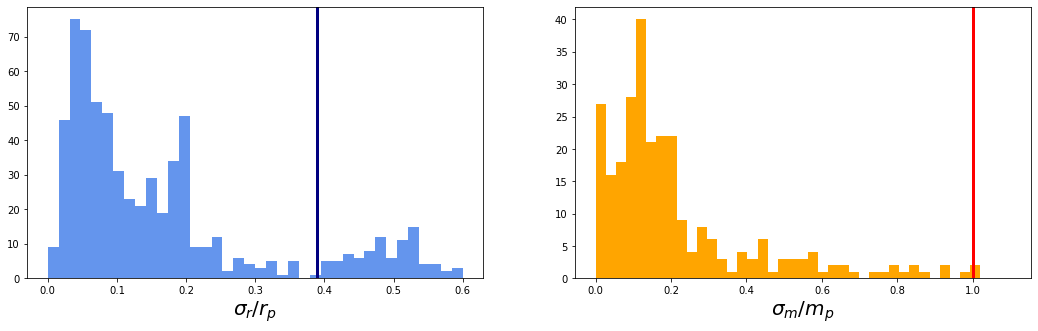

Removed planets with large uncertainties from the following systems
K2-183
K2-266
Kepler-148
Kepler-166
Kepler-171
Kepler-176
Kepler-178
Kepler-184
Kepler-191
Kepler-194
Kepler-222
Kepler-226
Kepler-228
Kepler-244
Kepler-250
Kepler-253
Kepler-254
Kepler-255
Kepler-272
Kepler-276
Kepler-288
Kepler-295
Kepler-301
Kepler-310
Kepler-325
Kepler-339
Kepler-341
Kepler-351
Kepler-357
Kepler-372
Kepler-374
Kepler-385
Kepler-399
Kepler-46
Kepler-47
Kepler-53
Kepler-58

After removals, 714 objects in 208 systems remain


In [16]:
# check for planets with large relative mass or radius uncertainties
mass_mu = np.copy(d["mp"])
mass_std = np.sqrt(d["mp_err1"]**2 + d["mp_err2"]**2)/np.sqrt(2)

radius_mu = np.copy(d["rp"])
radius_std = np.sqrt(d["rp_err1"]**2 + d["rp_err2"]**2)/np.sqrt(2)


# here's a histogram
fig, ax = plt.subplots(1,2, figsize=(18,5))
ax[0].hist(radius_std/radius_mu, bins=np.linspace(0,0.6,39), color="cornflowerblue")
ax[0].axvline(0.39, color="navy", lw=3)
ax[0].set_xlabel(r"$\sigma_r/r_p$", fontsize=20)
ax[1].hist(mass_std/mass_mu, bins=np.linspace(0,1.1,42), color="orange")
ax[1].axvline(1.0, color="red", lw=3)
ax[1].set_xlabel(r"$\sigma_m/m_p$", fontsize=20)
plt.show()


# remove the planets with large uncertainties
bad = (radius_std/radius_mu > 0.39) + (mass_std/mass_mu > 1.0)

print("Removed planets with large uncertainties from the following systems")
for star in np.unique(d["starname"][bad]):
    print(star)
    
for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removals, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))

./forecaster\mr_forecast.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  mass = truncnorm.rvs( (mlower-mean)/std, (mupper-mean)/std, loc=mean, scale=std, size=sample_size)


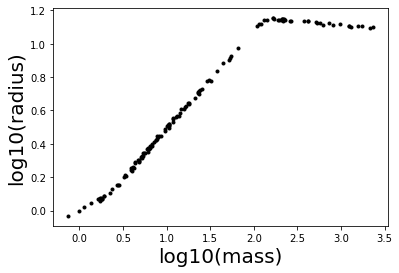

In [17]:
# determine the nominal minimum radius of any planet discovered by RVs
# use Chen & Kipping (2017) to convert mass to radius

rv_mass = d["mp"][d["disc_method"] == "Radial Velocity"]
rv_mass_err1 = d["mp_err1"][d["disc_method"] == "Radial Velocity"]
rv_mass_err2 = d["mp_err2"][d["disc_method"] == "Radial Velocity"]
rv_mass_err  = np.sqrt(rv_mass_err1**2 + rv_mass_err2**2)/np.sqrt(2)

bad = (rv_mass_err > 0.5*rv_mass) + np.isnan(rv_mass) + np.isnan(rv_mass_err)

rv_mass = rv_mass[~bad]
rv_mass_err = rv_mass_err[~bad]

rv_nominal_radius = np.zeros_like(rv_mass)
rv_stellar_radius = d["rs"][d["disc_method"] == "Radial Velocity"][~bad]

for i, rvm in enumerate(rv_mass):
    rv_nominal_radius[i] = mr.Mstat2R(rvm, rv_mass_err[i], sample_size=1000)[0]

min_rv_radius = np.min(rv_nominal_radius[~np.isnan(rv_nominal_radius)])
    
nominal_rprs = (rv_nominal_radius*REARTH)/(rv_stellar_radius*RSUN)
min_rv_rprs = np.min(nominal_rprs[~np.isnan(nominal_rprs)])

plt.figure()
plt.plot(np.log10(rv_mass), np.log10(rv_nominal_radius), "k.")
plt.xlabel("log10(mass)", fontsize=20)
plt.ylabel("log10(radius)", fontsize=20)
plt.show()

In [18]:
# remove very small transiting planets (that wouldn't be discovered by RV)
# remove very long period RV planets (that wouldn't be discovered by Kepler)
# don't throw out the NaN values, which indicate missing data (e.g no radius for some RV planets)

d['rprs'] = (d['rp']*REARTH)/(d['rs']*RSUN)

keep = (d["rprs"] >= min_rv_rprs) + ((np.isnan(d["rprs"]))+(d['rprs']==0) * (d["p"] < 1460.))
for k in d.keys():
    d[k] = d[k][keep]

    
# recount the planets in each system and eliminate systems reduced to fewer than 3 planets
for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    

print("After removing long period and small radius objects, {0} planets in {1} systems remain"
      .format(len(d["starname"]), len(np.unique(d["starname"]))))

After removing long period and small radius objects, 609 planets in 171 systems remain


In [19]:
# recount the planets in each system
d["npl"] = np.zeros(len(d["starname"]), dtype="int")

for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    

# remove systems with fewer than 3 planets and not Radial Velocity
keep = (d["npl"] >= 3)*(d['disc_method'] == 'Radial Velocity')

for k in d.keys():
    d[k] = d[k][keep]
    
print("After removing systems with N < 3, {0} objects in {1} systems remain"
      .format(np.sum(keep), len(np.unique(d["starname"]))))

After removing systems with N < 3, 137 objects in 38 systems remain


In [20]:
systems = []

for i, star in enumerate(np.unique(d['starname'])):
    use = d['starname'] == star
    
    s = System()
    
    s.starname = d['starname'][use][0]
    s.Mstar = d['ms'][use][0]
    s.Mstar_upper = d['ms_lower'][use][0]
    s.Mstar_lower = d['ms_upper'][use][0]
    s.Rstar = d['rs'][use][0]
    s.Rstar_upper = d['rs_lower'][use][0]
    s.Rstar_lower = d['rs_upper'][use][0]
    
    s.mag = d['mag'][use][0]
    s.temp = d['temp'][use][0]
    s.instrument = d['instrument'][use][0]
    s.ref = d['ref'][use][0]
    
    systems.append(s)

In [21]:
print(len(systems))

# Generates Latex table
# Need to implement formatting the reference

rows = []
for s in systems:
    row = [0]*11
    row[0] = s.starname
    row[1] = s.Mstar
    row[2] = s.Mstar_upper
    row[3] = s.Mstar_lower
    row[4] = s.Rstar
    row[5] = s.Rstar_upper
    row[6] = s.Rstar_lower
    row[7] = s.mag
    row[8] = s.temp
    row[9] = s.instrument
    row[10] = s.ref
    rows.append(row)

38


In [22]:
print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))


Tabulate Latex:
\begin{tabular}{lrrrrrrrrll}
\hline
 47 UMa    &   1.06 &   -0.13 &   0.13 &   1.21 &   -0.05 &   0.05 &   5.03352 &   5872.0 & Lick Observatory                   & \ensuremath{<}a refstr=STASSUN\_ET\_AL\_\_2019 href=https://ui.adsabs.harvard.edu/abs/2019AJ....158..138S/abstract target=ref\ensuremath{>}TICv8\ensuremath{<}/a\ensuremath{>}                               \\
\hline
 55 Cnc    &  1.015 &  -0.051 &  0.051 &  0.98  & -0.016  & 0.016  &   5.95084 &      nan & Lick Observatory                   & \ensuremath{<}a refstr=BALUEV\_2015 href=https://ui.adsabs.harvard.edu/abs/2015MNRAS.446.1493B/abstract target=ref\ensuremath{>}Baluev 2015\ensuremath{<}/a\ensuremath{>}                                 \\
 61 Vir    &  0.94  &  -0.03  &  0.03  &  0.96  & -0.01   & 0.01   &   4.6955  &     5577 & Multiple Observatories             & \ensuremath{<}a refstr=VOGT\_ET\_AL\_\_2010 href=https://ui.adsabs.harvard.edu/abs/2010ApJ...708.1366V/abstract target=ref\ensuremath{>} Vog